In [1]:
#Loading necessary packages and defining global variables
import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
from collections import defaultdict
import os
from torch.utils import data
import matplotlib.pyplot as plt
import pandas as pd
from sys import platform

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cpu")
OUTPUT_DIR_TRAIN='data/train.dat'
OUTPUT_DIR_TEST='data/test1.dat'

NUM_RESTS = 5138
NUM_USERS = 3579

In [2]:
def get_sparse_mat(filename):
  
    '''
    
    Inputs: 
        -filename: a string containing the name of the file from which we want
                    to extract the data. In our case it can be either train.dat
                    or test.dat
                    
    Returns a python list of size 3579 (number of users) with each element of
    the list being a list of tuples (restaurantID, rating).
    
    '''
    
    sparse_mat = []
    
    # YOUR CODE HERE
    with open(filename, 'r') as f:
        for line in f:
            user,res,rating = line.split(',')
            while len(sparse_mat)<=int(user):
                sparse_mat.append([])
            sparse_mat[int(user)].append((int(res),float(rating)))
    
    return sparse_mat

In [3]:
#Now that we have implemented the get_sparse_mat function we can get the train and test sparse matrices
train_smat = get_sparse_mat(OUTPUT_DIR_TRAIN)
test_smat = get_sparse_mat(OUTPUT_DIR_TEST)

In [4]:
class Dataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        X_sam = torch.zeros(5138)
        y_sam = torch.zeros(5138)
        for i in range(len(self.X[index])):
            X_sam[self.X[index][i][0]] = self.X[index][i][1]

        for i in range(len(self.y[index])):
            y_sam[self.y[index][i][0]] = self.y[index][i][1]

        return X_sam, y_sam

In [5]:
train_dataset = Dataset(train_smat,train_smat)
test_dataset = Dataset(train_smat, test_smat)

In [6]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 6 if platform == 'linux' else 0}
training_generator = data.DataLoader(train_dataset, **params)# sampler = torch.utils.data.SequentialSampler(train_dataset))
validation_generator = data.DataLoader(test_dataset, **params)# sampler = torch.utils.data.SequentialSampler(train_dataset))

In [7]:
class DAE(nn.Module):
    def __init__(self):
        '''
        Define the layers and activation functions to be used in the network.
        '''
        super(DAE,self).__init__()
        
        # YOUR CODE HERE
        h_size = 128
        h_size2 = 32
        self.layer1 = nn.Linear(5138,h_size)
        self.layer2 = nn.Linear(h_size,h_size2)
        self.layer3 = nn.Linear(h_size2,h_size)
        self.layer4 = nn.Linear(h_size,5138)
        
        self.act1 = nn.LeakyReLU()
        self.act2 = nn.Sigmoid()
        
    def forward(self, x, test=False):
        '''
        Implement the forward function which takes as input the tensor x and feeds it to the layers of the network
        and returns the output.
        
        Inputs:
            -x : Input tensor of shape [N_batch, 5138]
            
        Returns the output of neural network of shape [N_batch, 5138]
        '''
        
        out = torch.zeros(x.shape[0], 5138)
        
        # YOUR CODE HERE
        out = self.layer1(x/5)
        out = self.act1(out)
        out = self.layer2(out)
        out = self.act1(out)
        out = self.layer3(out)
        out = self.act1(out)
        out = self.layer4(out)
        if test==False:
            out=5*self.act2(out)
        else:
            out = 5*self.act2(out)
        return out

In [8]:
net = DAE()

In [9]:
def masked_loss(preds, labels):
    
    '''
    Inputs:
        -preds: Model predictions [N_batch, 5138]
        -labels: User ratings [N_batch, 5138]
        
    Returns the masked loss as described above.
    '''
    
    loss = 0
    
    # YOUR CODE HERE
    one = torch.ones(labels.shape)
    zero = torch.zeros(labels.shape)
    mask = torch.where(labels>0,one,zero)
    preds = preds*mask
    loss_matrix = (preds - labels)**2
    loss = torch.sum(loss_matrix)/torch.sum(mask)
    return loss

In [10]:
def train(net, criterion, opti, training_generator, validation_generator, max_epochs = 10):
    
    '''
    Inputs:
        - net: The model instance
        - criterion: Loss function, in our case it is masked_loss function.
        - opti: Optimizer Instance
        - training_generator: For iterating through the training set
        - validation_generator: For iterating through the test set
        - max_epochs: Number of training epochs. One epoch is defined as one complete presentation of the data set.
    
    Outputs:
        - train_losses: a list of size max_epochs containing the average loss for each epoch of training set.
        - val_losses: a list of size max_epochs containing the average loss for each epoch of test set.
        
        Note: We compute the average loss in an epoch by summing the loss at each iteration of that epoch
        and then dividing the sum by the number of iterations in that epoch.
    '''

    train_losses = []
    val_losses = []
    
    for epoch in range(max_epochs):
        running_loss = 0 #Accumulate the loss in each iteration of the epoch in this variable
        cnt = 0 #Increment it each time to find the number iterations in the epoch.
        # Training iterations
        for batch_X, batch_y in training_generator:
            opti.zero_grad() #Clears the gradients of all variables.
            scheduler.step()
            # YOUR CODE HERE
            output = net(batch_X,False)
            loss = criterion(output, batch_X)
            loss.backward()
            opti.step()
            running_loss+=loss.item()
            cnt+=1

        print("Epoch {}: Training Loss {}".format(epoch+1, running_loss/cnt))
        train_losses.append(running_loss/cnt)
        
        
        #Now that we have trained the model for an epoch, we evaluate it on the test set
        running_loss = 0
        cnt = 0
        with torch.set_grad_enabled(False):
            for batch_X, batch_y in validation_generator:

                # YOUR CODE HERE
                output = net(batch_X,True)
                loss = criterion(output, batch_y)
                running_loss+=loss.item()
                cnt+=1                
        print("Epoch {}: Validation Loss {}".format(epoch+1, running_loss/cnt))

        val_losses.append(running_loss/cnt)
        
    return train_losses, val_losses

In [11]:
net = DAE()
opti = optim.Adam(net.parameters(), lr = 5e-4, weight_decay=1e-06)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=opti, milestones=[i for i in range(20)], gamma=0.98)
train_losses, val_losses = train(net, masked_loss, opti, training_generator, validation_generator, 16)

Epoch 1: Training Loss 2.3883015172822133
Epoch 1: Validation Loss 1.6128761640616827
Epoch 2: Training Loss 0.9497249658618655
Epoch 2: Validation Loss 0.8540858307055065
Epoch 3: Training Loss 0.7260349169373512
Epoch 3: Validation Loss 0.7749890333839825
Epoch 4: Training Loss 0.6453759766050747
Epoch 4: Validation Loss 0.7105590967195374
Epoch 5: Training Loss 0.58583925185459
Epoch 5: Validation Loss 0.665977274200746
Epoch 6: Training Loss 0.5472237861582211
Epoch 6: Validation Loss 0.6425413457410676
Epoch 7: Training Loss 0.5262659075004714
Epoch 7: Validation Loss 0.6304491119725364
Epoch 8: Training Loss 0.5142126248351165
Epoch 8: Validation Loss 0.6237762320254531
Epoch 9: Training Loss 0.5056282792772565
Epoch 9: Validation Loss 0.6185223247323718
Epoch 10: Training Loss 0.49900017199771746
Epoch 10: Validation Loss 0.6135887216244426
Epoch 11: Training Loss 0.49203513615897726
Epoch 11: Validation Loss 0.6100382474916322
Epoch 12: Training Loss 0.48766848338501795
Epoch 1

Text(0.5, 0, 'Epochs')

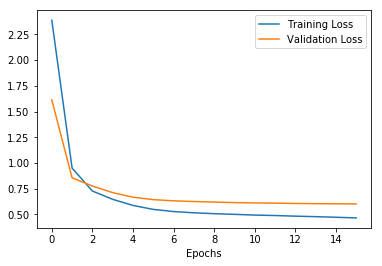

In [12]:
# Finally we plot the graphs for loss vs epochs.
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')

In [13]:
x, y = test_dataset.__getitem__(4)
pred = net(x,True)
print("Predicted Ratings: ", pred[y!=0].detach().numpy())
print("Actual Ratings: ", y[y!=0].numpy())

Predicted Ratings:  [3.6989436 3.4803524 3.6116233 3.954351  4.3224487]
Actual Ratings:  [3.5 3.5 4.  4.  4. ]


In [14]:
def get_predictions(net, train_data = train_smat):
    
    def get_test_smat(filename = 'data/test_hidden.dat'):
        sparse_dict = defaultdict(list)
        for line in open(filename):
            splitted_line = line.split(',')
            sparse_dict[int(splitted_line[0])].append((int(splitted_line[1])))

        sparse_mat = []
        sKeys = sorted(sparse_dict)
        for key in sKeys:
            sparse_mat.append(sparse_dict[key])
        
        return sparse_mat
            
            
    test_smat = get_test_smat()
    preds = []
    for i in range(len(train_data)):
        
        #Getting the actual vector from the sparse representation
        x = torch.zeros(5138)
        for j in range(len(train_data[i])):
            x[train_data[i][j][0]] = train_data[i][j][1]
        with torch.set_grad_enabled(False):
            pred = net(x).detach().numpy() ## This logic might be different for your model, change this accordingly
        
        pred = pred[test_smat[i]]
        user_rest_pred = np.concatenate([i*np.ones((len(pred),1),dtype=np.int),np.array(test_smat[i],dtype=np.int)[:,None], np.array(pred)[:,None]],axis = 1)
        preds += user_rest_pred.tolist()
        
    preds = np.array(preds)
    df = pd.DataFrame(preds)
    df[0] = df[0].astype('int')
    df[1] = df[1].astype('int')
    df[2] = df[2].astype('float16')
    df = df.drop(df.columns[[0, 1]], axis=1)
    df['index1'] = df.index.values
    df.columns = ['rating', 'id']
    df = df[['id','rating']]
    df.to_csv('predictions.csv', index=False, header=True)    
    return df

In [16]:
df = get_predictions(net)
df.head()

,id,rating
0,0,4.570312
1,1,3.589844
2,2,3.996094
3,3,4.777344
4,4,3.902344
